In [1]:
import os
import re
import cv2
import json
import array
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import OpenEXR
import Imath
from mpl_toolkits.mplot3d import Axes3D
from scipy import ndimage
from collections import defaultdict
import matplotlib.patches as mpatches

In [2]:
def generate_cognitive_map(instance_mask, xyz_map, id_to_class, p_camera, grid_size=(20, 20), min_points=400):
    """
    参数:
        instance_mask: H x W 的 numpy 数组，实例分割图，每个像素是实例ID
        xyz_map: H x W x 3 的 numpy 数组，存储每个像素的世界坐标 (x, y, z)
        id_to_class: 字典 {instance_id: class_name}
        p_camera: 相机位置 (3,)
        grid_size: 网格大小 (rows, cols)
        min_points: 每个实例最少多少个像素点

    返回:
        显示空间认知图（以 x-z 平面为投影）
    """
    instance_positions = {}
    for instance_id in np.unique(instance_mask):
        if instance_id == 0:
            continue  # 忽略背景
        mask = instance_mask == instance_id
        coords = xyz_map[mask]
        coords = coords[~np.isnan(coords).any(axis=1)]
        if len(coords) < min_points:
            continue
        center = np.median(coords, axis=0)  # 得到物体中心
        instance_positions[instance_id] = np.array(center, dtype=np.float64).reshape(3,)
    
    # 加入相机坐标，id=-1
    # p_camera = np.array(p_camera, dtype=np.float64).reshape(3,)
    instance_positions[-1] = p_camera

    # 计算所有中心点在 XZ 平面的最小/最大值
    all_centers = np.array(list(instance_positions.values()))
    min_xz = np.min(all_centers[:, [0, 2]], axis=0)
    max_xz = np.max(all_centers[:, [0, 2]], axis=0)

    # 构建网格
    grid = [[[] for _ in range(grid_size[1])] for _ in range(grid_size[0])]

    for inst_id, center in instance_positions.items():
        x, z = center[0], center[2]
        norm_x = (x - min_xz[0]) / (max_xz[0] - min_xz[0] + 1e-6)
        norm_z = (z - min_xz[1]) / (max_xz[1] - min_xz[1] + 1e-6)

        grid_x = min(int(norm_x * grid_size[1]), grid_size[1] - 1)
        grid_y = min(int(norm_z * grid_size[0]), grid_size[0] - 1)

        label = id_to_class.get(inst_id, "Camera" if inst_id == -1 else f"id{inst_id}")
        # beam(横梁)\ceiling(天花板)\floor(地板)不纳入考虑
        if label == "beam" or label == "ceiling" or label == "floor":
            continue
        grid[grid_y][grid_x].append(label)

    # 绘制认知图（俯视 X-Z 方向）
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_xlim(0, grid_size[1])
    ax.set_ylim(0, grid_size[0])
    ax.invert_yaxis()
    ax.set_xticks(np.arange(0, grid_size[1]+1))
    ax.set_yticks(np.arange(0, grid_size[0]+1))
    ax.grid(True)

    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            items = grid[i][j]
            if items:
                label = '\n'.join(sorted(set(items)))
                # 相机位置用红色标出
                text_color = 'red' if "Camera" in label else 'black'
                ax.text(j + 0.5, i + 0.5, label, ha='center', va='center', fontsize=8, color=text_color)

    ax.set_title("Spatial Cognitive Map (Top-down view on X-Z plane)", fontsize=16)
    plt.tight_layout()
    plt.show()
    # fig.savefig("cognitive_map.png", dpi=300, bbox_inches='tight')

In [3]:
# 读取exr文件
def read_exr( image_fpath ):
    """ Reads an openEXR file into an RGB matrix with floats """
    f = OpenEXR.InputFile( image_fpath )
    dw = f.header()['dataWindow']
    w, h = (dw.max.x - dw.min.x + 1, dw.max.y - dw.min.y + 1)    
    im = np.empty( (h, w, 3) )

    # Read in the EXR
    FLOAT = Imath.PixelType(Imath.PixelType.FLOAT)
    channels = f.channels( ["R", "G", "B"], FLOAT )
    for i, channel in enumerate( channels ):
        im[:,:,i] = np.reshape( array.array( 'f', channel ), (h, w) )
    return im

""" Label functions """
def load_labels( label_file ):
    """ Convenience function for loading JSON labels """
    with open( label_file ) as f:
        return json.load( f )

def parse_label( label ):
    """ Parses a label into a dict """
    res = {}
    clazz, instance_num, room_type, room_num, area_num = label.split( "_" )
    res[ 'instance_class' ] = clazz
    res[ 'instance_num' ] = int( instance_num )
    res[ 'room_type' ] = room_type
    res[ 'room_num' ] = int( room_num )
    res[ 'area_num' ] = int( area_num )
    return res

def get_index(color):
    """ Parse a color as a base-256 number and return the index """
    r, g, b = map(int, color)  # 👈 转换为 Python int 类型，避免 uint8 溢出
    return r * 256 * 256 + g * 256 + b

In [4]:
# 确定相机位置
def estimate_camera_position_from_equirectangular(
    xyz_image: np.ndarray,
    depth_map_raw: np.ndarray,
    rgb_image: np.ndarray
) -> np.ndarray:
    """
    从 equirectangular 图像、深度图和 3D 点图中计算相机位置。

    参数:
        xyz_image: (H, W, 3) 的 float32 数组，表示每个像素的 3D 世界坐标。
        depth_map_raw: (H, W) 的 uint16 数组，深度图，每个像素值代表 1/512 米。
        rgb_image: (H, W, 3) 的 uint8 数组，用于尺寸验证。

    返回:
        camera_position: (3,) numpy 数组，表示估计的相机在世界坐标中的位置。
    """
    H, W = rgb_image.shape[:2]

    # Step 1: 将原始深度图转换为 float32 单位米
    depth_map = depth_map_raw.astype(np.float32) / 512.0

    # Step 2: 生成单位方向向量（从相机指向像素方向）
    u = np.linspace(0, 1, W, endpoint=False)
    v = np.linspace(0, 1, H, endpoint=False)
    uu, vv = np.meshgrid(u, v)

    theta = 2 * np.pi * (uu - 0.5)  # 水平 [-π, π]
    phi = np.pi * (vv - 0.5)        # 垂直 [-π/2, π/2]

    ray_dirs = np.stack([
        np.cos(phi) * np.sin(theta),  # x
        np.sin(phi),                  # y
        np.cos(phi) * np.cos(theta)   # z
    ], axis=-1)  # shape: (H, W, 3)

    # Step 3: 创建有效像素掩码（排除无效深度和 NaN）
    valid = (~np.isnan(xyz_image).any(axis=-1)) & (depth_map_raw != 65535)
    valid_xyz = xyz_image[valid]
    valid_depth = depth_map[valid]
    valid_dirs = ray_dirs[valid]

    if len(valid_xyz) == 0:
        raise ValueError("没有有效像素用于估计相机位置，请检查输入。")

    # Step 4: 对每个像素使用反投影公式反推相机位置
    cam_candidates = valid_xyz - valid_depth[:, np.newaxis] * valid_dirs

    # Step 5: 取平均以增强鲁棒性
    camera_position = np.mean(cam_candidates, axis=0)

    return camera_position

In [6]:
semantic_label_path = "../../../PanoCode/2D-3D-Semantics/assets/semantic_labels.json"
pano_dir = "../../../PanoData/area_3/area_3/pano/rgb"
xyz_dir = "../../../PanoData/area_3/area_3/pano/global_xyz"
instance_dir = "../../../PanoData/area_3/area_3/pano/semantic"
depth_dir = "../../../PanoData/area_3/area_3/pano/depth"

In [7]:
# 全景图像
pano_list = os.listdir(pano_dir)
print(len(pano_list))
pano_name = pano_list[43]
print(pano_name)
pano_name = "camera_b4ea4a673c654438b4e0218c74467c49_lounge_2_frame_equirectangular_domain_rgb.png"
pano_path = os.path.join(pano_dir, pano_name)
# 实例分割标签
instance_name = pano_name.replace('rgb', 'semantic')
instance_path = os.path.join(instance_dir, instance_name)
# 3D标注
xyz_name = pano_name.replace('rgb.png', 'global_xyz.exr')
xyz_path = os.path.join(xyz_dir, xyz_name)
# 深度图
depth_name = pano_name.replace('rgb.png', 'depth.png')
depth_path = os.path.join(depth_dir, depth_name)

86
camera_614b84a8cd784710afb803d9d3dc8612_office_10_frame_equirectangular_domain_rgb.png


In [8]:
# 读取深度图
depth_image = np.array(Image.open(depth_path))
# 读取3D标注
xyz_image = read_exr(xyz_path)
# 读取实例分割标签
instance_image = Image.open(instance_path)
np_instance_image = np.array(instance_image)
semantic_labels = load_labels(semantic_label_path)
instance_index = np.zeros([2048, 4096])
# 映射到实例分割物体分类的Index
for i in range(2048):
    for j in range(4096):
        class_index = get_index(np_instance_image[i, j])
        if class_index < 9816:
            instance_index[i, j] = class_index
        else:
            instance_index[i, j] = 0
instance_ids = np.unique(instance_index)
instance_ids = instance_ids[instance_ids < 9816]
# class_index-class_name映射
id_map = dict()
for inst_id in instance_ids:
    # 在标签中寻找这个inst_id对应的实例类别
    label = parse_label(semantic_labels[int(inst_id)])
    id_map[inst_id] = label["instance_class"]

In [9]:
# 接下来估计相机的位置
pano_image = np.array(Image.open(pano_path))
p_camera = estimate_camera_position_from_equirectangular(xyz_image, depth_image, pano_image)
print(p_camera)
id_map[-1] = "Camera"

[ 8.77773673 -4.98492859  1.26960746]


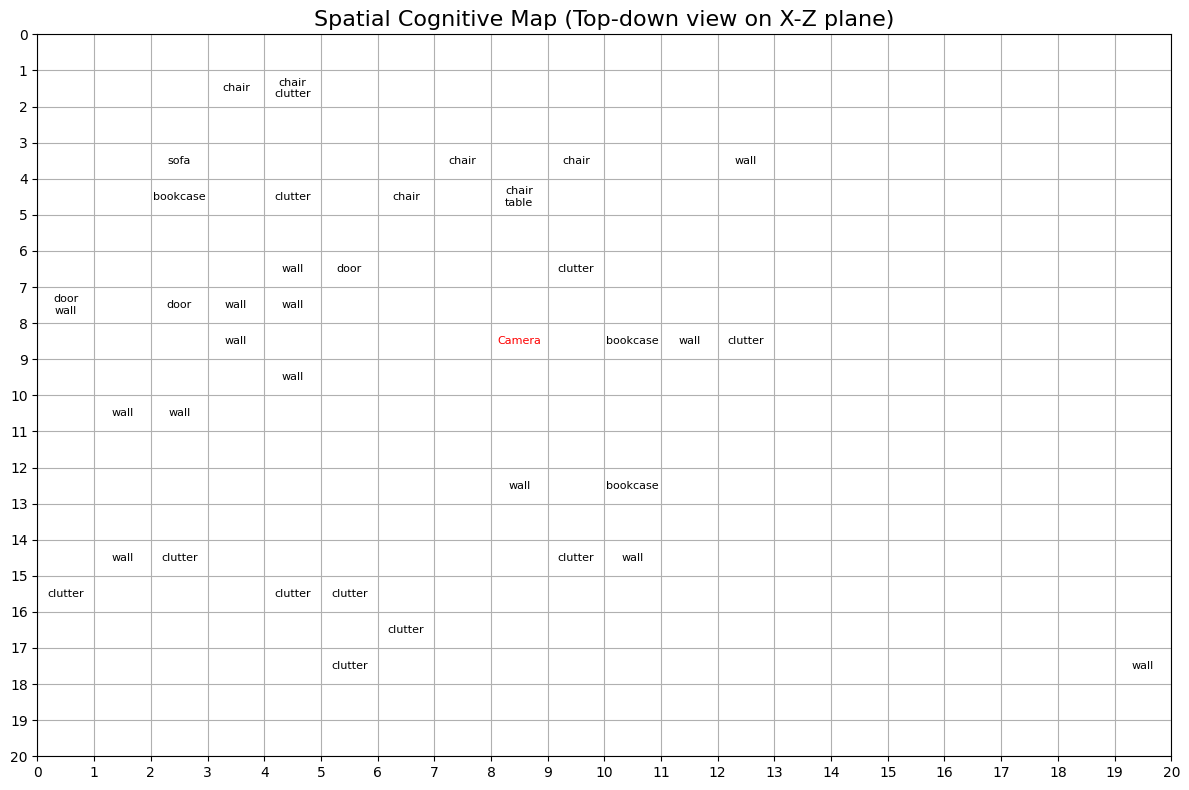

In [10]:
# 生成认知图
generate_cognitive_map(instance_index, xyz_image, id_map, p_camera)

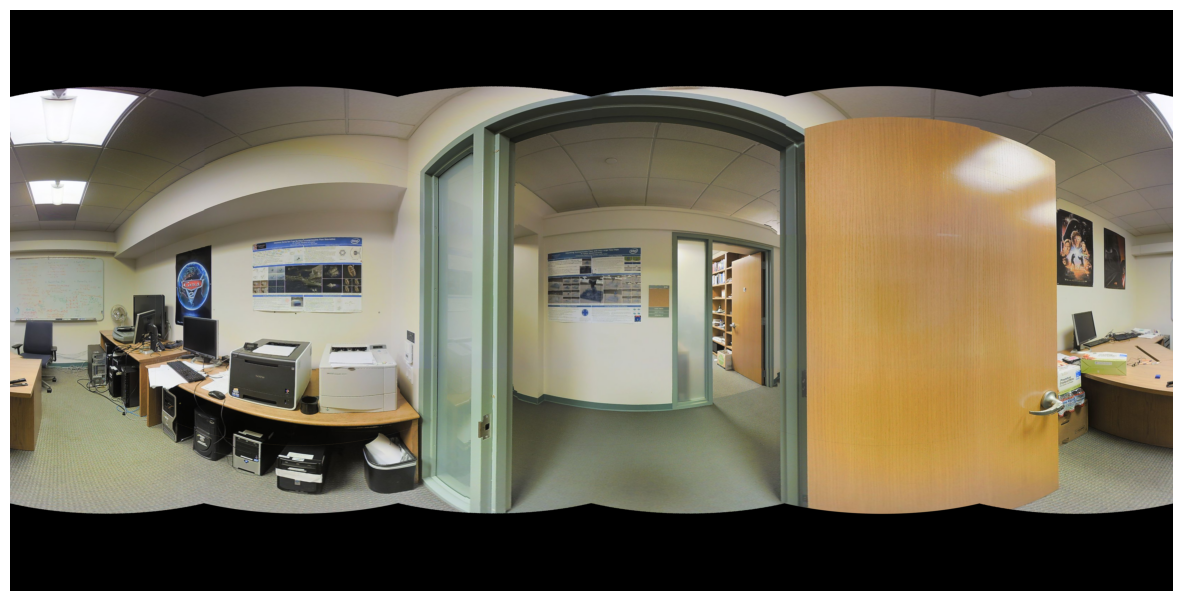

In [23]:
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
axis.imshow(pano_image)
axis.axis('off')
fig.savefig("pano_output.png", dpi=300, bbox_inches='tight')

In [29]:
# 获取所有有效点（去除 nan）
points3d = xyz_image.reshape(-1, 3)
valid_points = points3d[~np.isnan(points3d).any(axis=1)]

# 估计相机位置：所有点的“球壳中心”或中值点
estimated_cam_pos = np.median(valid_points, axis=0)  # 更鲁棒于离群点
print(estimated_cam_pos)

[14.87621784  2.59332108  1.38049442]


In [38]:
# 检查深度图
depth_image = np.array(Image.open(depth_path))
print(depth_image.shape)
print(np.unique(depth_image))
print(depth_image.dtype)

(2048, 4096)
[  249   250   251 ...  3610  3639 65535]
uint16
